In [1]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import re
import joblib

## Data Loading and Initial Inspection

In [3]:
# Load data
data = pd.read_csv(r"C:\Users\HP\Downloads\Hostel_Prices.csv")

In [4]:
# Initial inspection
print(f"Data Dimensions: {data.shape}")
print("\nMissing Values:")
print(data.isnull().sum())
print("\nData Sample:")
print(data.head())

Data Dimensions: (502, 30)

Missing Values:
gender                        22
age_group                      0
level_of_study                 2
lecture_location               2
accommodation_type             1
faculty                        1
off_campus_duration            1
room_category                  2
annual_rent                    2
includes_water                 2
includes_electricity           3
includes_waste_disposal        1
has_running_water              2
has_extra_storage              8
has_wifi_internet             16
has_study_area                 9
has_security_services         13
has_generator_backup_power     9
hostel_distance_minutes        0
commute_mode                   1
room_size                      0
furnished_bed                  0
furnished_table                2
furnished_chairs               3
has_access_controls           12
has_janitorial_services       10
required_deposit               2
recent_rent_increase           8
avg_rent_nearby                5

## Data Cleaning

In [5]:
# Rename columns for clarity and consistency
new_columns = {
    'level_of_study': 'study_level',
    'lecture_location': 'campus_location',
    'accommodation_type': 'room_type',
    'off_campus_duration': 'stay_duration',
    'room_category': 'room_category',
    'includes_water': 'water_included',
    'includes_electricity': 'electricity_included',
    'includes_waste_disposal': 'waste_disposal_included',
    'has_running_water': 'running_water',
    'has_extra_storage': 'extra_storage',
    'has_wifi_internet': 'wifi',
    'has_study_area': 'study_area',
    'has_security_services': 'security',
    'has_generator_backup_power': 'generator_backup',
    'hostel_distance_minutes': 'commute_time',
    'room_size': 'room_size',
    'furnished_bed': 'furnished_bed',
    'furnished_table': 'furnished_table',
    'furnished_chairs': 'furnished_chairs',
    'has_access_controls': 'access_control',
    'has_janitorial_services': 'janitorial_services',
    'required_deposit': 'deposit',
    'recent_rent_increase': 'rent_increase',
    'avg_rent_nearby': 'avg_area_rent'
}

data = data.rename(columns=new_columns)

In [6]:
# Conversion functions for numerical ranges
def convert_commute_time(value):
    """Convert commute time range to average minutes"""
    if pd.isna(value):
        return np.nan
    numbers = re.findall(r'\d+', str(value))
    if len(numbers) >= 2:
        return (float(numbers[0]) + float(numbers[1])) / 2
    elif len(numbers) == 1:
        return float(numbers[0])
    return np.nan

def convert_room_size(value):
    """Convert room size range to average square meters"""
    if pd.isna(value):
        return np.nan
    numbers = re.findall(r'\d+', str(value))
    if len(numbers) >= 2:
        return (float(numbers[0]) + float(numbers[1])) / 2
    elif len(numbers) == 1:
        return float(numbers[0])
    return np.nan

# Apply conversions
data['commute_time'] = data['commute_time'].apply(convert_commute_time)
data['room_size'] = data['room_size'].apply(convert_room_size)

# Drop rows with missing target variable
data = data.dropna(subset=['annual_rent'])

In [10]:
# Impute missing values

# Numerical columns: Group-based median Imputation
num_cols = ['deposit', 'rent_increase', 'avg_area_rent', 'commute_time', 'room_size']
for col in num_cols:
    data[col] = data.groupby('room_type')[col].transform(lambda x: x.fillna(x.median()))
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_7412\1968725645.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_7412\1968725645.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

In [11]:
# Impute missing values

# Categorical columns: Group-based mode Imputation
cat_cols = [
    'gender', 'age_group', 'study_level', 'campus_location', 'room_type',
    'faculty', 'stay_duration', 'water_included', 'electricity_included',
    'waste_disposal_included', 'running_water', 'extra_storage', 'wifi',
    'study_area', 'security', 'generator_backup', 'commute_mode',
    'furnished_bed', 'furnished_table', 'furnished_chairs', 'access_control',
    'janitorial_services', 'hostel_location', 'room_category'
]

data['room_category'].fillna(data['room_category'].mode()[0], inplace=True)
for col in cat_cols:
    data[col] = data.groupby('room_category')[col].transform(
        lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x
    )
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mode()[0], inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_7412\546289854.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['room_category'].fillna(data['room_category'].mode()[0], inplace=True)


In [12]:
# Cleaning categorical variables
data['study_level'] = data['study_level'].str.replace('Post Graduate', 'Postgraduate')
data['room_type'] = data['room_type'].str.replace(r'\(.*\)', '', regex=True)

In [14]:
# Final Data Cleaning Verification
print("\nFinal Missing Values Count:")
print(data.isnull().sum())


Final Missing Values Count:
gender                     0
age_group                  0
study_level                0
campus_location            0
room_type                  0
faculty                    0
stay_duration              0
room_category              0
annual_rent                0
water_included             0
electricity_included       0
waste_disposal_included    0
running_water              0
extra_storage              0
wifi                       0
study_area                 0
security                   0
generator_backup           0
commute_time               0
commute_mode               0
room_size                  0
furnished_bed              0
furnished_table            0
furnished_chairs           0
access_control             0
janitorial_services        0
deposit                    0
rent_increase              0
avg_area_rent              0
hostel_location            0
dtype: int64


## Data Exploration

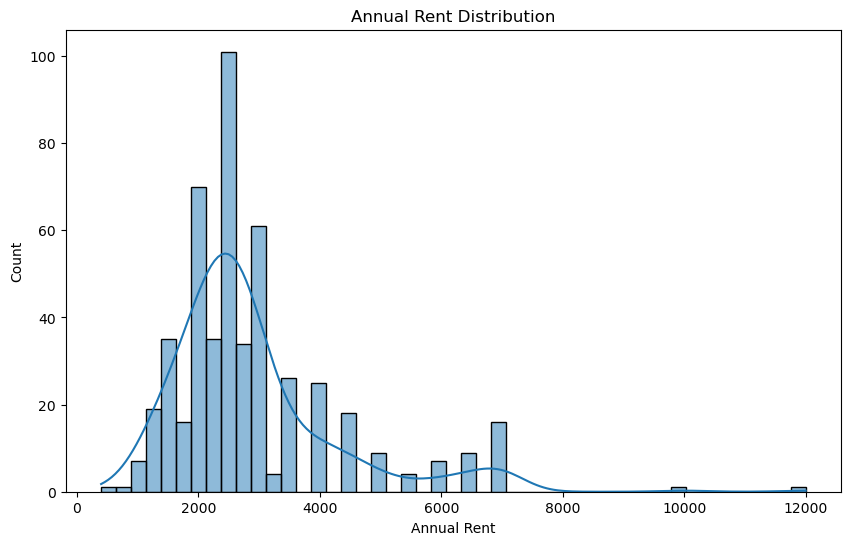

In [15]:
# Visualize target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['annual_rent'], kde=True)
plt.title('Annual Rent Distribution')
plt.xlabel('Annual Rent')
plt.show()

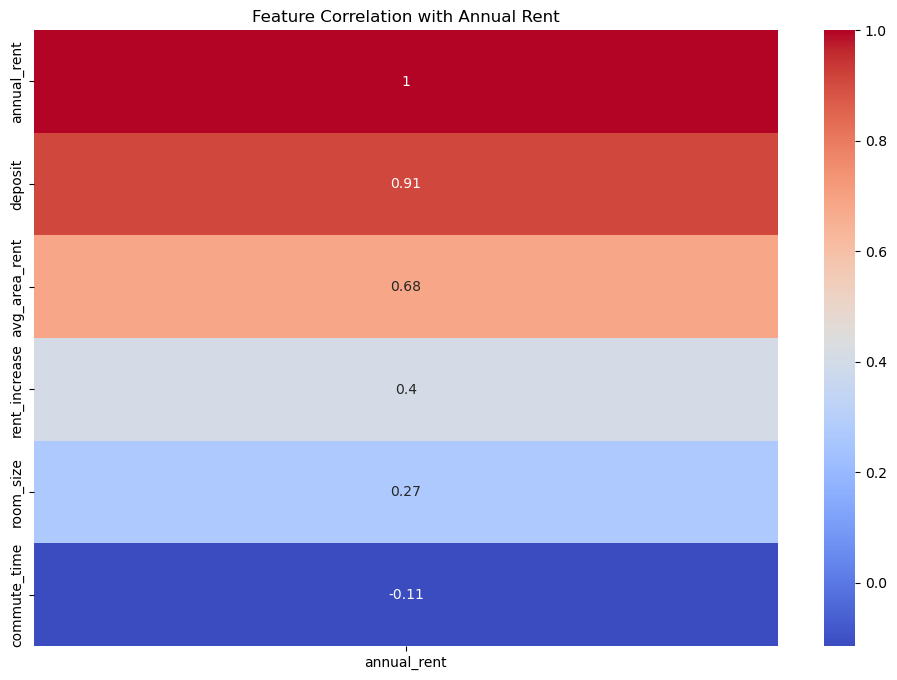

In [16]:
# Correlation Analysis

corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['annual_rent']].sort_values('annual_rent', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation with Annual Rent')
plt.show()

In [17]:
# Print top 5 correlated features
print("\nTop 5 Features Correlated with Annual Rent:")
print(corr_matrix['annual_rent'].abs().sort_values(ascending=False).head(5))


Top 5 Features Correlated with Annual Rent:
annual_rent      1.000000
deposit          0.912872
avg_area_rent    0.683504
rent_increase    0.404769
room_size        0.265787
Name: annual_rent, dtype: float64


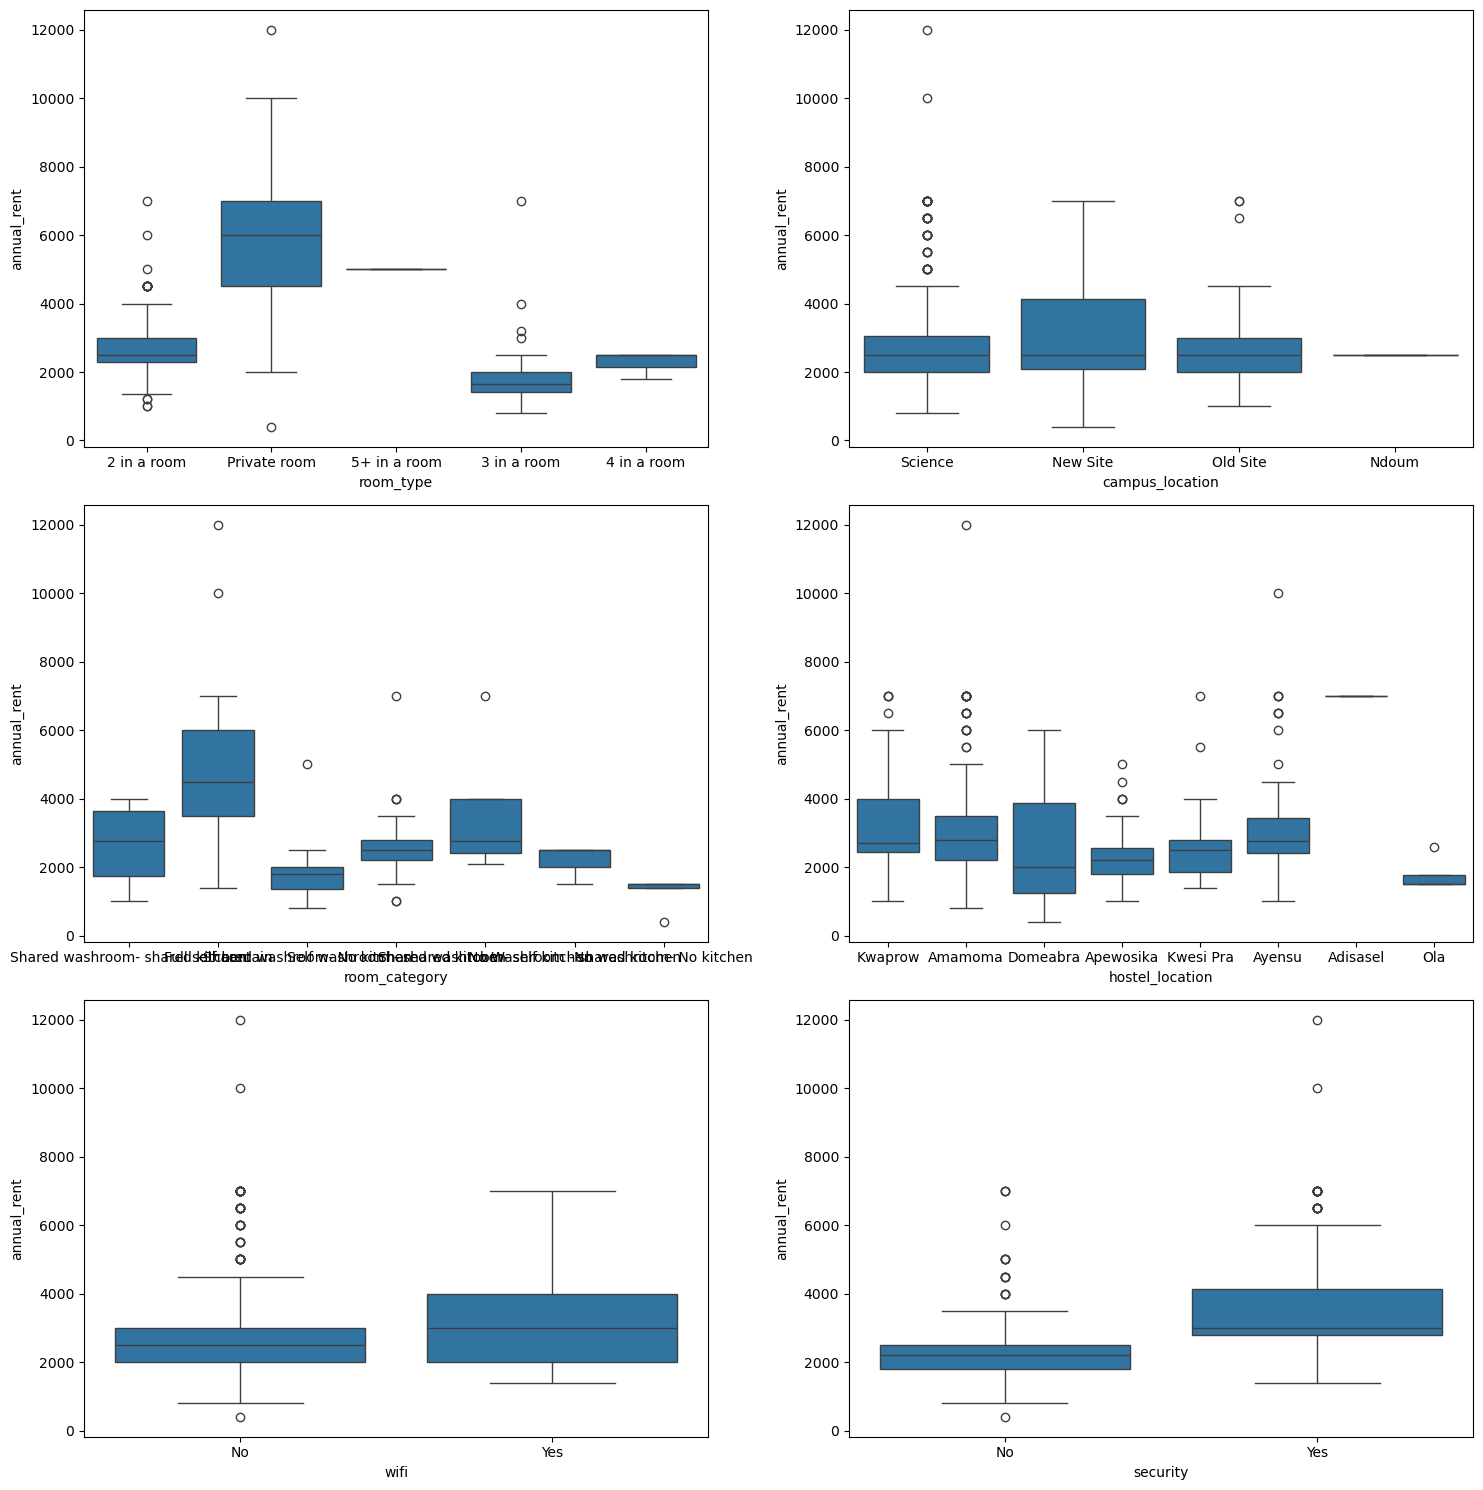

In [18]:
# Categorical Feature Analysis

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
sns.boxplot(x='room_type', y='annual_rent', data=data, ax=ax[0, 0])
sns.boxplot(x='campus_location', y='annual_rent', data=data, ax=ax[0, 1])
sns.boxplot(x='room_category', y='annual_rent', data=data, ax=ax[1, 0])
sns.boxplot(x='hostel_location', y='annual_rent', data=data, ax=ax[1, 1])
sns.boxplot(x='wifi', y='annual_rent', data=data, ax=ax[2, 0])
sns.boxplot(x='security', y='annual_rent', data=data, ax=ax[2, 1])
plt.tight_layout()
plt.show()

## Feature Engineering

In [19]:
# Convert amenities to binary
amenity_cols = [
    'water_included', 'electricity_included', 'waste_disposal_included', 'running_water',
    'extra_storage', 'wifi', 'study_area', 'security', 'generator_backup', 'access_control',
    'janitorial_services'
]
for col in amenity_cols:
    data[col] = data[col].map({'Yes': 1, 'No': 0, np.nan: 0})

In [20]:
# Create new features
data['furnishing_score'] = (
    data['furnished_bed'].map({'Yes': 1, 'No': 0}) +
    data['furnished_table'].map({'Yes': 1, 'No': 0}) +
    data['furnished_chairs'].map({'Yes': 1, 'No': 0})
)

In [21]:
# Creating a new feature: Total number of amenities
data['total_amenities'] = data[amenity_cols].sum(axis=1)

In [23]:
# New feature: Rent-to-deposit ratio
data['rent_to_deposit_ratio'] = data['annual_rent'] / (data['deposit'] + 1)  # Adding 1 to avoid division by zero

In [24]:
# New feature: Distance-weighted rent
data['distance_weighted_rent'] = data['avg_area_rent'] / (data['commute_time'] + 1) # Adding 1 to avoid division by zero

In [27]:
# Log-transform skewed features
data['log_annual_rent'] = np.log1p(data['annual_rent'])
data['log_avg_area_rent'] = np.log1p(data['avg_area_rent'])
data['log_deposit'] = np.log1p(data['deposit'])

# Drop redundant columns
data = data.drop(columns=['furnished_bed', 'furnished_table', 'furnished_chairs'])

In [31]:
# Updating the feature lists
num_features = ['deposit', 'rent_increase', 'avg_area_rent', 'commute_time', 'room_size',
                'furnishing_score', 'total_amenities', 'rent_to_deposit_ratio',
                'distance_weighted_rent', 'log_avg_area_rent', 'log_deposit']

cat_features = [col for col in cat_cols if col not in
                ['furnished_bed', 'furnished_table', 'furnished_chairs']]

## Data Preprocessing

In [32]:
# Train-test split
X = data.drop(['annual_rent', 'log_annual_rent'], axis=1)
y = data['log_annual_rent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Preprocessing pipeline

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

## Model Building

In [34]:
# Initialize models with hyperparameter tuning
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}


In [35]:
# Hyperparameter grids for tuning
param_grids = {
    'Random Forest': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [10, 20, None],
        'regressor__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 5, 7]
    }
} 

## Model Training and Evaluation

In [37]:
# Train and evaluate models
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Perform grid search for tree-based models
    if name in param_grids:
        grid_search = GridSearchCV(
            pipeline,
            param_grids[name],
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        pipeline = grid_search.best_estimator_
        print(f"{name} Best Parameters: {grid_search.best_params_}")
    else:
        pipeline.fit(X_train, y_train)
        
    # Predictions
    y_pred_log = pipeline.predict(X_test)
    log_min, log_max = y_train.min(), y_train.max()
    y_pred_log_clipped = np.clip(y_pred_log, log_min, log_max)
    y_test_actual = np.expm1(y_test)
    y_pred_actual = np.expm1(y_pred_log_clipped)
    
    # Handle potential infinite values
    max_float = np.finfo(np.float64).max / 10
    y_pred_actual = np.where(np.isinf(y_pred_actual), max_float, y_pred_actual)
    
    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    r2 = r2_score(y_test_actual, y_pred_actual)
    
    # Cross-validation score
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'CV_RMSE': cv_rmse,
        'model': pipeline
    }
    print(f"{name}: RMSE = {rmse:.2f}, R² = {r2:.4f}, CV RMSE = {cv_rmse:.2f}")

Linear Regression: RMSE = 1295.23, R² = 0.0188, CV RMSE = 234291797448.97
Ridge Regression: RMSE = 389.65, R² = 0.9112, CV RMSE = 0.39
Random Forest Best Parameters: {'regressor__max_depth': 20, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Random Forest: RMSE = 339.67, R² = 0.9325, CV RMSE = 0.13
Gradient Boosting Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300}
Gradient Boosting: RMSE = 240.47, R² = 0.9662, CV RMSE = 0.10
XGBoost Best Parameters: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__n_estimators': 300}
XGBoost: RMSE = 198.56, R² = 0.9769, CV RMSE = 0.10


In [38]:
# Compare model performance
performance_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(performance_df.sort_values(by='RMSE'))


Model Performance Comparison:
                          RMSE        R2              CV_RMSE  \
XGBoost             198.562237   0.97694              0.10404   
Gradient Boosting    240.46632   0.96618             0.104664   
Random Forest       339.666689  0.932521              0.12698   
Ridge Regression    389.645737  0.911202             0.390179   
Linear Regression  1295.226234  0.018806  234291797448.968384   

                                                               model  
XGBoost            (ColumnTransformer(transformers=[('num',\n    ...  
Gradient Boosting  (ColumnTransformer(transformers=[('num',\n    ...  
Random Forest      (ColumnTransformer(transformers=[('num',\n    ...  
Ridge Regression   (ColumnTransformer(transformers=[('num',\n    ...  
Linear Regression  (ColumnTransformer(transformers=[('num',\n    ...  


 ## Model Evaluation and Selection

In [39]:
# Identify best model
best_model_name = performance_df['RMSE'].idxmin()
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")


Best Model: XGBoost


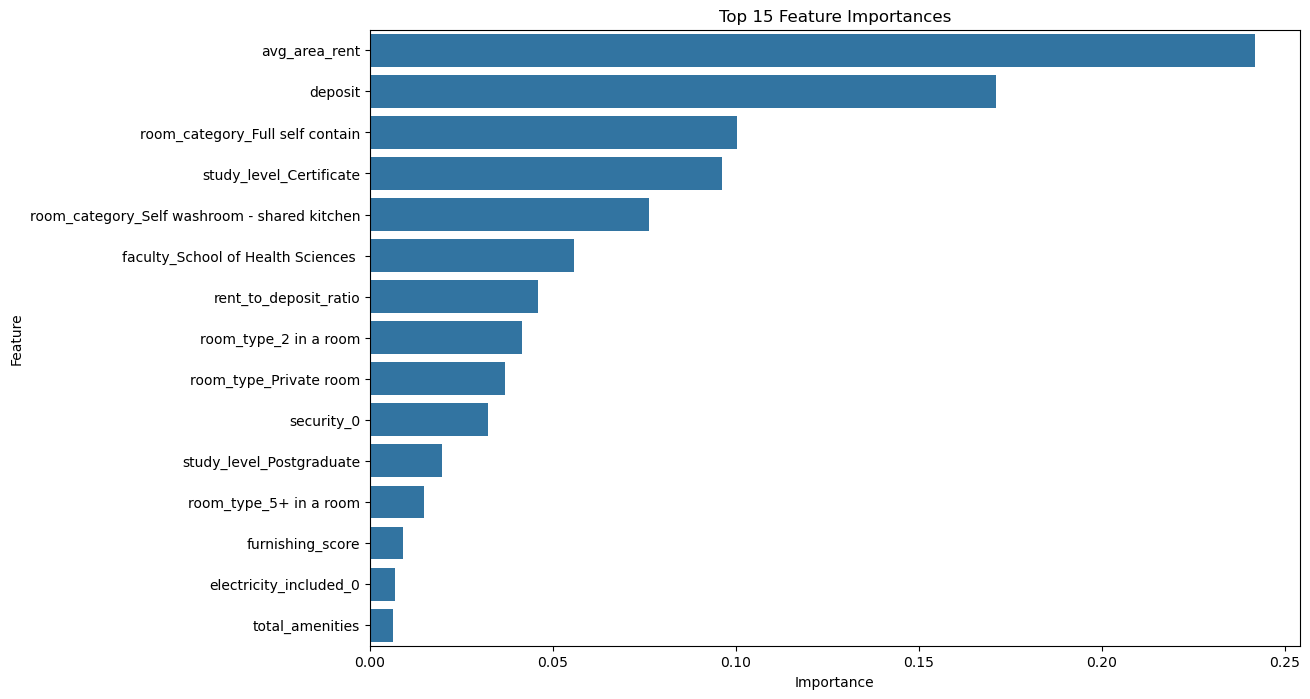

In [40]:
# Feature importance for tree-based models

if 'Random Forest' in best_model_name or 'Gradient Boosting' in best_model_name or 'XGBoost' in best_model_name:
    feature_importances = best_model.named_steps['regressor'].feature_importances_
    ohe_features = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)
    all_features = np.concatenate([num_features, ohe_features])
    
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title('Top 15 Feature Importances')
    plt.show()

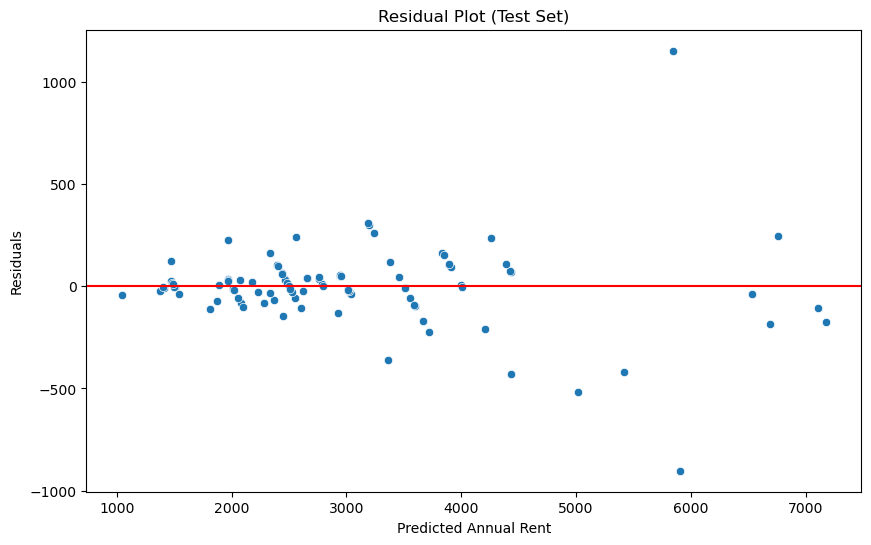

In [41]:
# Residual analysis
y_pred_test = best_model.predict(X_test)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.expm1(y_pred_test), y=np.expm1(y_test) - np.expm1(y_pred_test))
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot (Test Set)')
plt.xlabel('Predicted Annual Rent')
plt.ylabel('Residuals')
plt.show()

## Model Deployment

In [42]:
# Save the best model
joblib.dump(best_model, 'ucc_hostel_rent_predictor.pkl')

# Save sample input schema
sample_input = X_train.iloc[:1].copy()
joblib.dump(sample_input, 'hostel_sample_input.pkl')

['hostel_sample_input.pkl']